# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be 0 and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
print(filtered_data.shape) 
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'from', 're', 'more', 'what', 'out', 'having', 'll', 'o', 'has', "hasn't", "it's", "hadn't", 'ma', "wouldn't", 'but', "shan't", 'herself', 'down', 'ain', 'had', 'am', 'same', 'our', 'why', 'she', 'the', 'this', 'he', 'just', 'yours', 'whom', 'about', 'too', 'for', 'who', 't', 'during', 'were', 'shouldn', 'won', 'me', 'are', 'so', 'most', "couldn't", 'nor', 'only', "shouldn't", 'which', "you've", 'aren', 'then', 'there', 'such', 'does', 'as', 'each', 'an', 'than', 'above', "doesn't", 'now', 'y', 'into', 'own', 'by', 'any', 'against', "aren't", "you'd", 'is', 'with', 'did', 'haven', 'mustn', 'those', 'further', 'while', 'these', "isn't", 'before', 'be', 'your', 'been', "haven't", 'their', 'themselves', 'didn', 'shan', "you're", 'them', 'that', 'they', "mustn't", 'how', 'in', "won't", 'of', 'was', 'wasn', 'where', 'him', 'at', 'doesn', 'couldn', 'until', 'some', 'over', 'yourself', 'both', 'can', 'hadn', 'i', 'mightn', 'have', 'very', 'it', 'once', "don't", 'being', 'because', "didn't", 

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [15]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [16]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [17]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [18]:
print(cleaned_data.shape)
cleaned_data.head(2)

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [19]:
cleaned_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [20]:
# To randomly sample 100k points from both class
random_sample_data = final.sample(n=100000) 
random_sample_data.shape

(100000, 11)

In [21]:
# Sort data based on time
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)

In [22]:
final_sorted_time.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,b'bought apart infest fruit fli hour trap mani...


In [23]:
#data splitting
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [24]:
train_data=final_sorted_time['CleanedText'][0:49000]
cv_data=final_sorted_time['CleanedText'][49000:70000]
test_data=final_sorted_time['CleanedText'][70000:100000]

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
count_vector = CountVectorizer()
bow_train = count_vector.fit_transform(train_data)
bow_cv  = count_vector.transform(cv_data)
bow_test= count_vector.transform(test_data)

In [26]:
print(bow_train.shape)
print(bow_cv.shape)
bow_test.shape

(49000, 26790)
(21000, 26790)


(30000, 26790)

## [4.2] TF-IDF

In [27]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_train = tfidf_vec.fit_transform(train_data)
tf_cv  = tfidf_vec.transform(cv_data)
tf_test = tfidf_vec.transform(test_data)

## [4.3] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
list_of_sent_train = []
for i in train_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)

In [29]:
list_of_sent_cv = []
for i in cv_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_cv.append(sent)

In [30]:
list_of_sent_test = []
for i in test_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)

In [31]:
print(len(list_of_sent_train))
print(len(list_of_sent_cv))
len(list_of_sent_test)

49000
21000


30000

In [32]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_train,min_count = 5,size = 50,workers = 4)

In [33]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9317
sample words  ['twist', 'captur', 'film', 'star', 'michael', 'keaton', 'geena', 'davi', 'prime', 'tim', 'burton', 'masterpiec', 'rumbl', 'absurd', 'wonder', 'pace', 'point', 'dull', 'moment', 'bought', 'apart', 'infest', 'fruit', 'fli', 'hour', 'trap', 'mani', 'within', 'day', 'practic', 'gone', 'may', 'long', 'term', 'solut', 'drive', 'crazi', 'consid', 'buy', 'one', 'surfac', 'sticki', 'tri', 'avoid', 'touch', 'realli', 'good', 'idea', 'final', 'product']


## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

In [34]:
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

49000


In [35]:
sent_vectors_cv = []
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))

21000


In [36]:
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

30000


#### [4.3.1.2] TFIDF weighted W2v

In [37]:
tfidf_vector = TfidfVectorizer()
tfidf_train = tfidf_vector.fit_transform(train_data)
tf_idf_feat = tfidf_vector.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    
    tfidf_sent_vec_train.append(sent_vec)
    row += 1

In [38]:
tfidf_sent_vec_cv = []
row = 0
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_cv[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_cv.append(sent_vec)
    row += 1

In [39]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of depth is :  50
The optimal value of min split is :  500


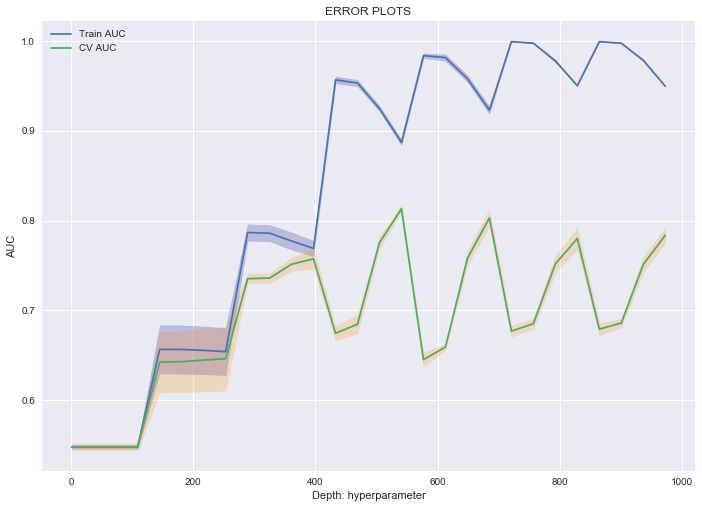

In [116]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
train_auc_std = []
cv_auc_std = []

l=np.arange(1,1000,36)


Depths=[1, 5, 10, 50, 100, 500, 1000]
min_split= [5, 10, 100, 500]

param_grid = {'max_depth': Depths, 'min_samples_split': min_split}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1, pre_dispatch=2)
model.fit(bow_train, y_train)

train_auc = model.cv_results_['mean_train_score']
train_auc_std = model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

print("Model with best parameters :\n",model.best_estimator_)
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

#Optimal value of min_samples_split
optimal_split = model.best_estimator_.min_samples_split
print("The optimal value of min split is : ",optimal_split)


plt.plot(l, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(l, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

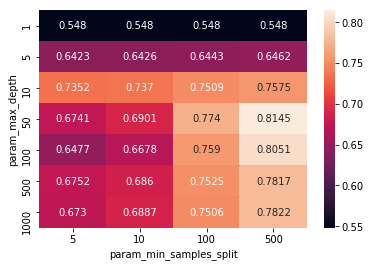

In [41]:
#Depths=[1, 5, 10, 50, 100, 500, 1000]
#min_split= [5, 10, 100, 500]
#param_grid = {'max_depth': Depths, 'min_samples_split': min_split}

df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.show()

In [42]:
results = pd.DataFrame(model.cv_results_)

In [43]:
results = results.sort_values(by='mean_test_score', ascending=False)

In [44]:
results[['mean_test_score', 'param_max_depth', 'param_min_samples_split']].round(3).head()

,mean_test_score,param_max_depth,param_min_samples_split
15,0.815,50,500
19,0.805,100,500
27,0.782,1000,500
23,0.782,500,500
14,0.774,50,100


In [46]:
model.best_score_

0.8145436984402511

In [47]:
pred_train= model.predict(bow_train)
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 3048,  3890],
       [ 1322, 40740]], dtype=int64)

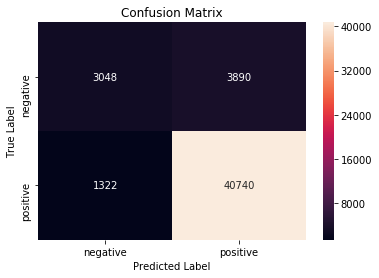

In [48]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Results on test data

In [111]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth= 50, min_samples_split= 500)
clf.fit(bow_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

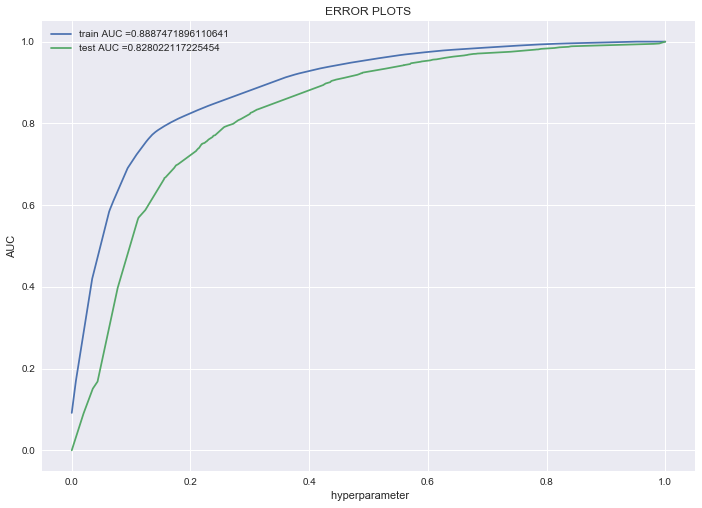

In [112]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(bow_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(bow_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel(" hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [113]:
pred = clf.predict(bow_test)
pred_prob = clf.predict_proba(bow_test)[:,1]

In [114]:
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on test data: 0.828022117225454


In [117]:
# Variables that will be used for  making table in Conclusion part of this assignment
from sklearn.metrics import roc_auc_score
depth = optimal_depth
split = optimal_split

pred_proba_cv = model.predict_proba(bow_cv)[:,1]
bow_cv_auc = roc_auc_score(y_cv, pred_proba_cv)
bow_test_auc=roc_auc_score(y_test, pred_prob)

In [57]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 2017,  3228],
       [ 1056, 23699]], dtype=int64)

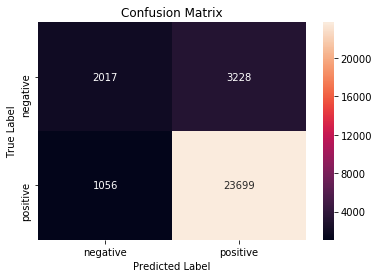

In [58]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [59]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.66      0.38      0.48      5245
          1       0.88      0.96      0.92     24755

avg / total       0.84      0.86      0.84     30000



### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [60]:
importances = clf.feature_importances_

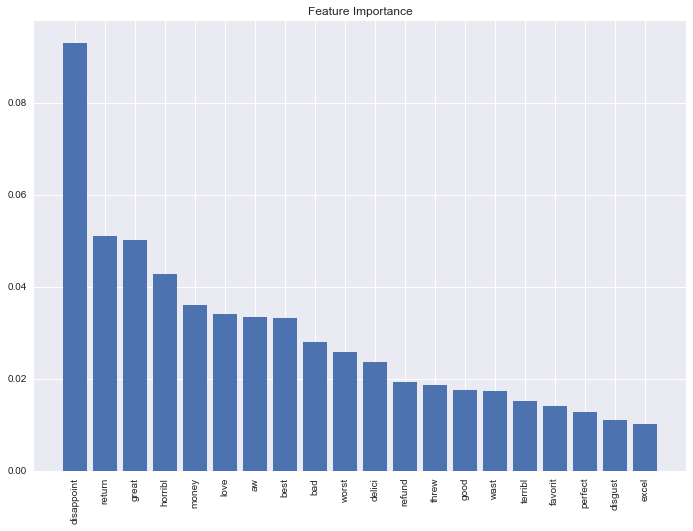

In [61]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:20]

# Rearrange feature names so they match the sorted feature importances
names = count_vector.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(20), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(20), names[indices], rotation=90)

# Show plot
plt.show()

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

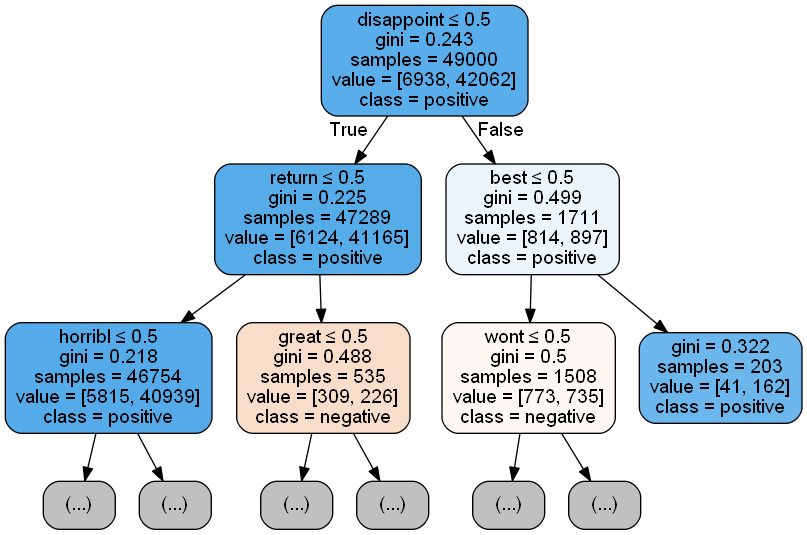

In [65]:
# Importing libraries
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
names = count_vector.get_feature_names()
target = ['negative','positive']

# Create DOT data
data = tree.export_graphviz(clf,out_file=None,class_names=target,feature_names = names, max_depth=2, filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of depth is :  50
The optimal value of min split is :  500


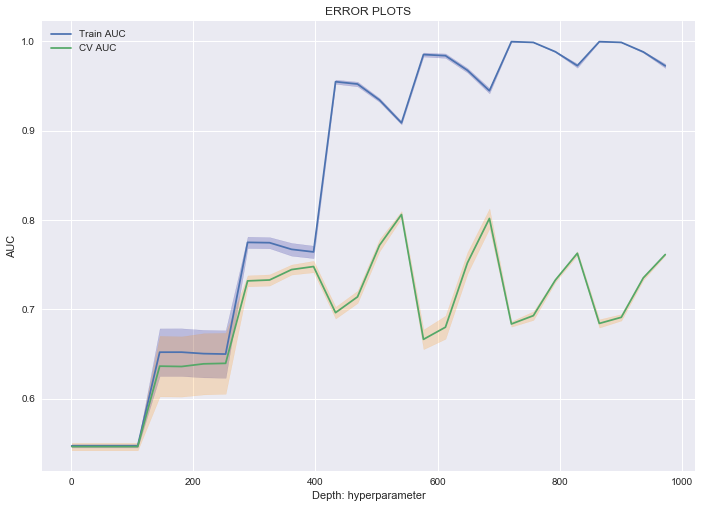

In [66]:
train_auc = []
cv_auc = []
train_auc_std = []
cv_auc_std = []

l=np.arange(1,1000,36)


Depths=[1, 5, 10, 50, 100, 500, 1000]
min_split= [5, 10, 100, 500]

param_grid = {'max_depth': Depths, 'min_samples_split': min_split}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1, pre_dispatch=2)
model.fit(tf_train, y_train)

train_auc = model.cv_results_['mean_train_score']
train_auc_std = model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

print("Model with best parameters :\n",model.best_estimator_)
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

#Optimal value of min_samples_split
optimal_split = model.best_estimator_.min_samples_split
print("The optimal value of min split is : ",optimal_split)


plt.plot(l, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(l, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

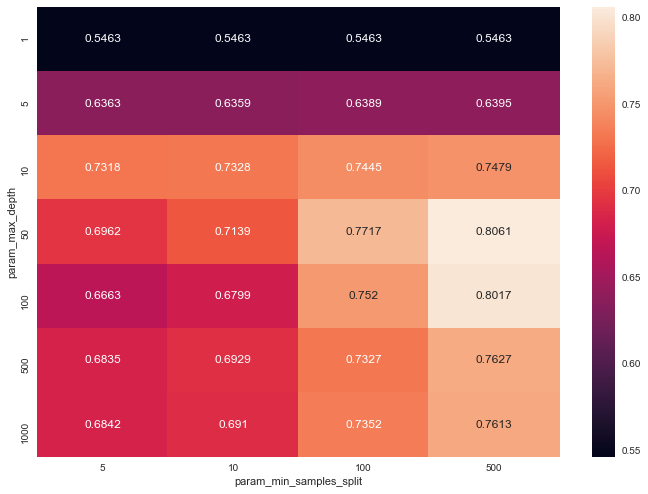

In [67]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.show()

In [68]:
pred_train= model.predict(tf_train)

In [69]:
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 3682,  3256],
       [ 1428, 40634]], dtype=int64)

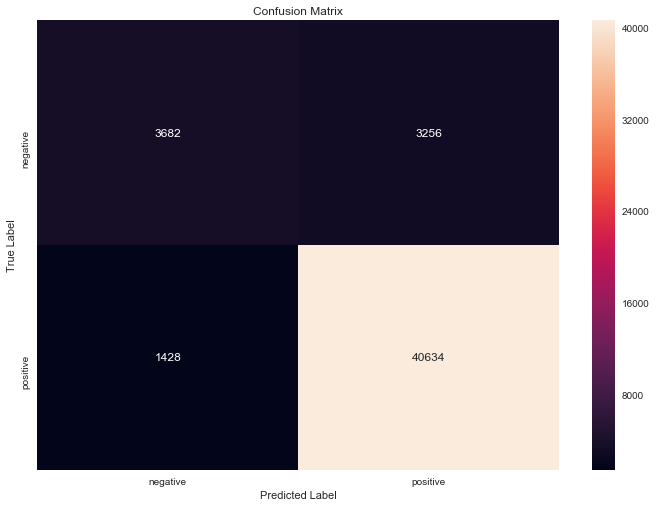

In [70]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on test data

In [119]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth= 50, min_samples_split= 500)
clf.fit(tf_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

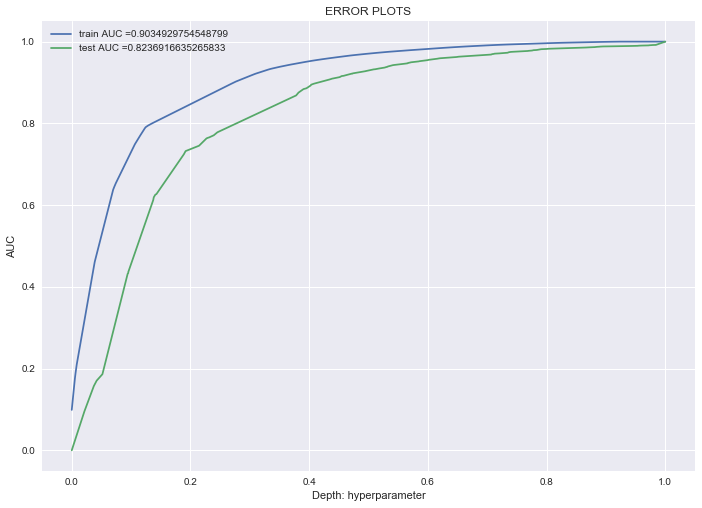

In [120]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(tf_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(tf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [72]:
pred = clf.predict(tf_test)
pred_prob = clf.predict_proba(tf_test)[:,1]

In [73]:
# Variables that will be used for  making table in Conclusion part of this assignment
tf_depth = optimal_depth
tf_split = optimal_split

pred_proba_cv = model.predict_proba(tf_cv)[:,1]
tf_cv_auc = roc_auc_score(y_cv, pred_proba_cv)
tf_test_auc=roc_auc_score(y_test, pred_prob)

print("AUC value on test data:",tf_test_auc)

AUC value on test data: 0.8229377162156724


In [74]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 2263,  2982],
       [ 1291, 23464]], dtype=int64)

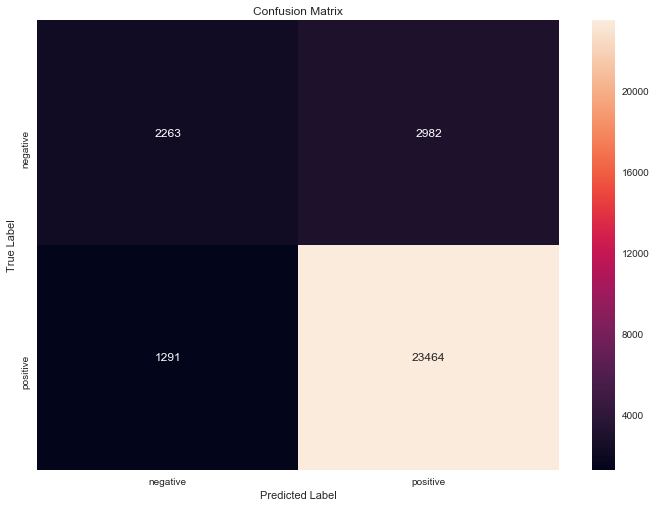

In [75]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [76]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.64      0.43      0.51      5245
          1       0.89      0.95      0.92     24755

avg / total       0.84      0.86      0.85     30000



### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

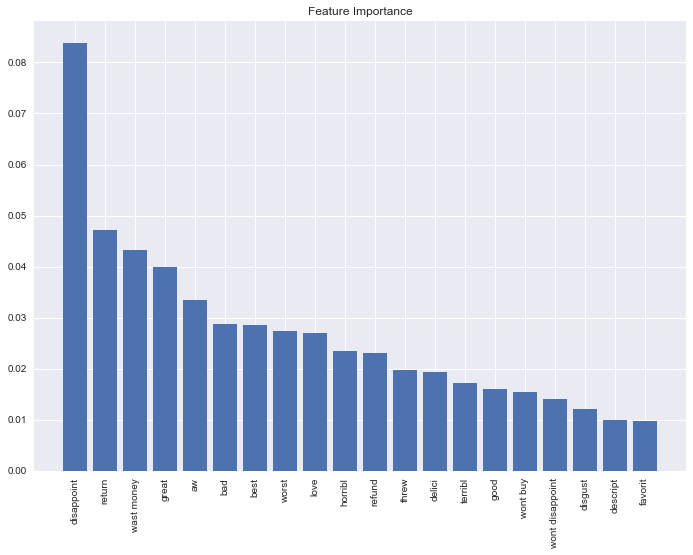

In [77]:
importances = clf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:20]

# Rearrange feature names so they match the sorted feature importances
names = tfidf_vec.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(20), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(20), names[indices], rotation=90)

# Show plot
plt.show()


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

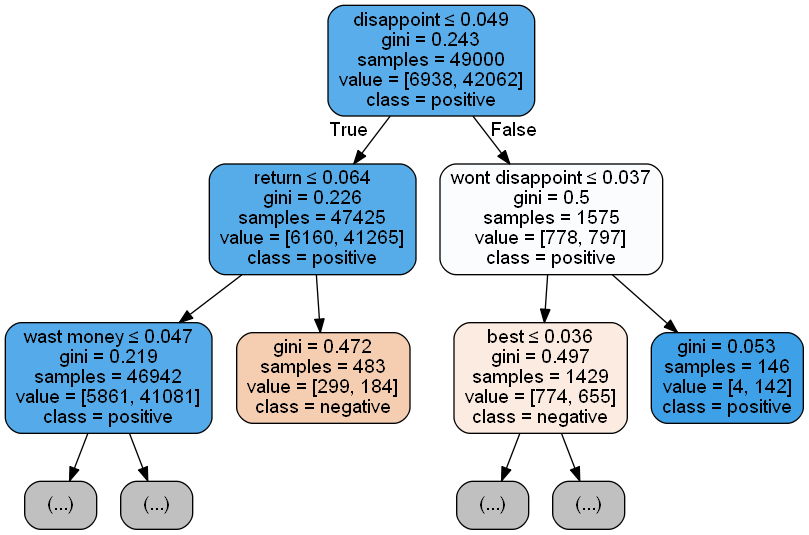

In [78]:
target = ['negative','positive']
names_tf = tfidf_vec.get_feature_names()

# Create DOT data
data = tree.export_graphviz(clf,out_file=None,class_names=target,feature_names= names_tf, max_depth=2, filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of depth is :  10
The optimal value of min split is :  500


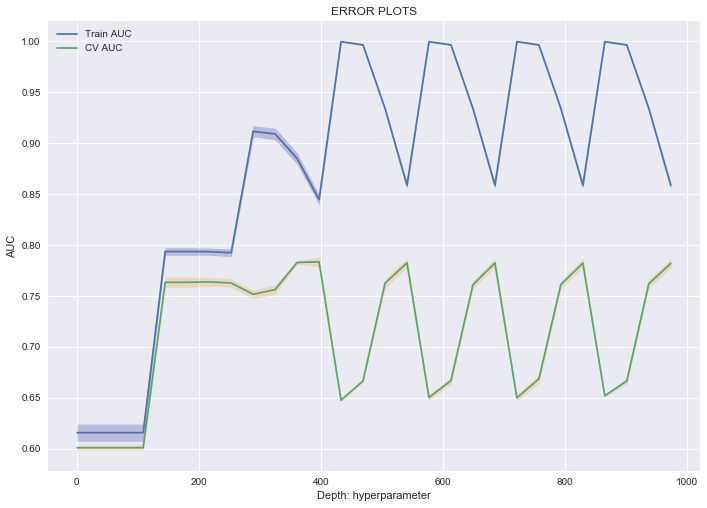

In [79]:
train_auc = []
cv_auc = []
train_auc_std = []
cv_auc_std = []

l=np.arange(1,1000,36)


Depths=[1, 5, 10, 50, 100, 500, 1000]
min_split= [5, 10, 100, 500]

param_grid = {'max_depth': Depths, 'min_samples_split': min_split}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1, pre_dispatch=2)
model.fit(sent_vectors_train, y_train)

train_auc = model.cv_results_['mean_train_score']
train_auc_std = model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

print("Model with best parameters :\n",model.best_estimator_)
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

#Optimal value of min_samples_split
optimal_split = model.best_estimator_.min_samples_split
print("The optimal value of min split is : ",optimal_split)


plt.plot(l, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(l, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

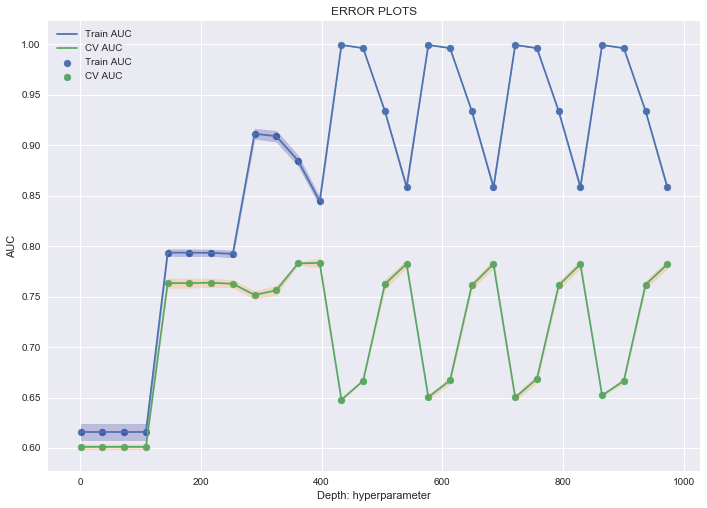

In [80]:
plt.plot(l, train_auc, label='Train AUC')
plt.scatter(l, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(l, cv_auc, label='CV AUC')
plt.scatter(l, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

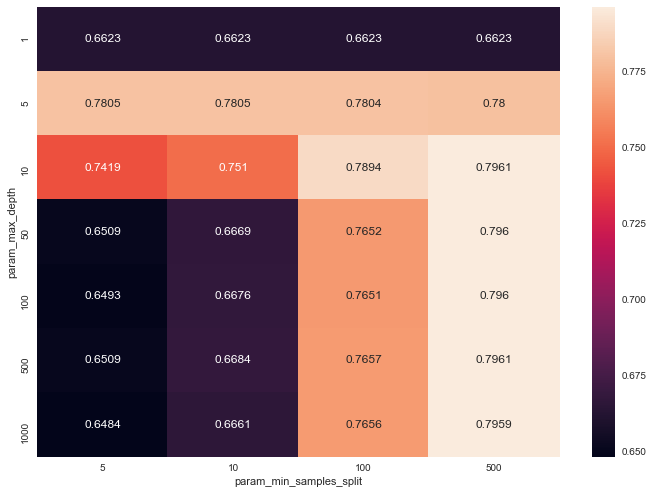

In [88]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.show()

In [81]:
pred_train= model.predict(sent_vectors_train)

In [82]:
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 1810,  5128],
       [ 1030, 41032]], dtype=int64)

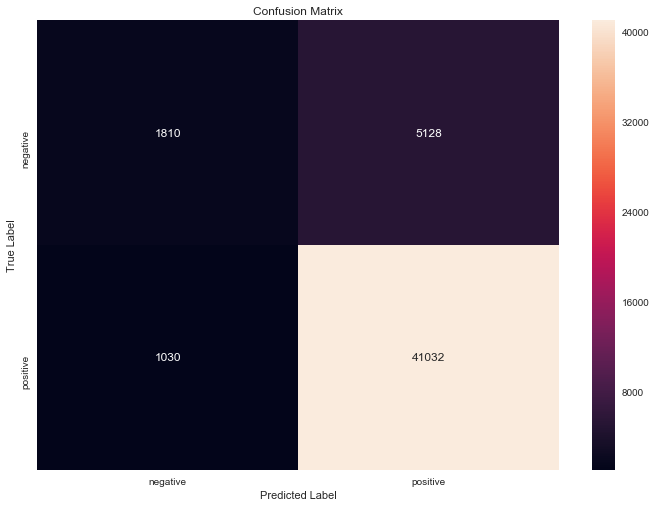

In [83]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on Test data

In [84]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth= 10, min_samples_split= 500)
clf.fit(sent_vectors_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

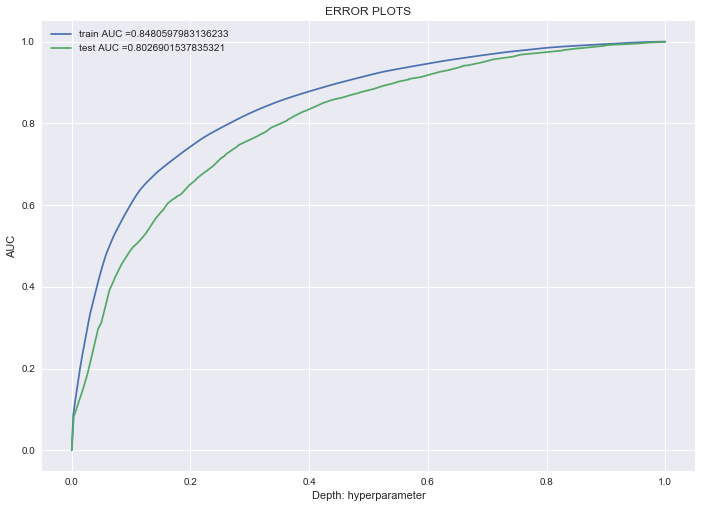

In [89]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [86]:
pred = clf.predict(sent_vectors_test)
pred_prob = clf.predict_proba(sent_vectors_test)[:,1]

In [87]:
# Variables that will be used for  making table in Conclusion part of this assignment
bow_depth = optimal_depth
bow_split = optimal_split

pred_proba_cv = model.predict_proba(sent_vectors_cv)[:,1]
avg_cv_auc = roc_auc_score(y_cv, pred_proba_cv)
avg_test_auc=roc_auc_score(y_test, pred_prob)

print("AUC value on test data:", avg_test_auc)

AUC value on test data: 0.8026901537835321


In [90]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 1279,  3966],
       [  791, 23964]], dtype=int64)

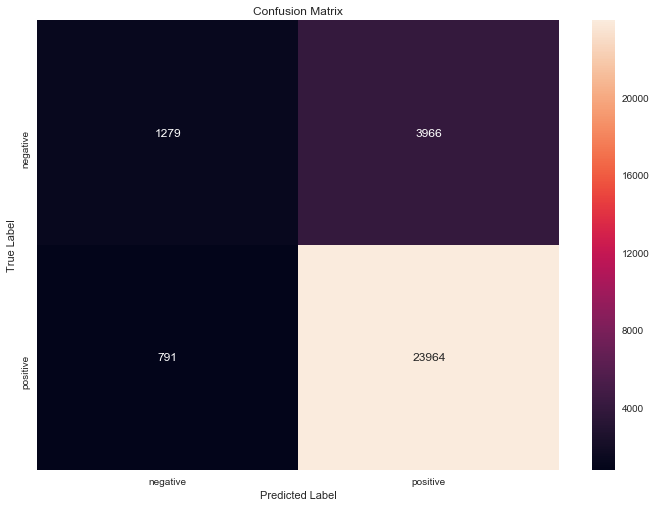

In [91]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [92]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.62      0.24      0.35      5245
          1       0.86      0.97      0.91     24755

avg / total       0.82      0.84      0.81     30000



## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [93]:
tfw2v_train= np.array(tfidf_sent_vec_train)
tfw2v_train.shape

(49000, 50)

In [94]:
tfw2v_cv= np.array(tfidf_sent_vec_cv)
tfw2v_cv.shape

(21000, 50)

In [95]:
tfw2v_test= np.array(tfidf_sent_vec_test)
tfw2v_test.shape

(30000, 50)

In [96]:
#Hyperparameter tuning
train_auc = []
cv_auc = []
train_auc_std = []
cv_auc_std = []

l=np.arange(1,1000,36)


Depths=[1, 5, 10, 50, 100, 500, 1000]
min_split= [5, 10, 100, 500]

param_grid = {'max_depth': Depths, 'min_samples_split': min_split}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1, pre_dispatch=2)
model.fit(tfw2v_train, y_train)

train_auc = model.cv_results_['mean_train_score']
train_auc_std = model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

print("Model with best parameters :\n",model.best_estimator_)
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

#Optimal value of min_samples_split
optimal_split = model.best_estimator_.min_samples_split
print("The optimal value of min split is : ",optimal_split)

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=500,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of depth is :  500
The optimal value of min split is :  5


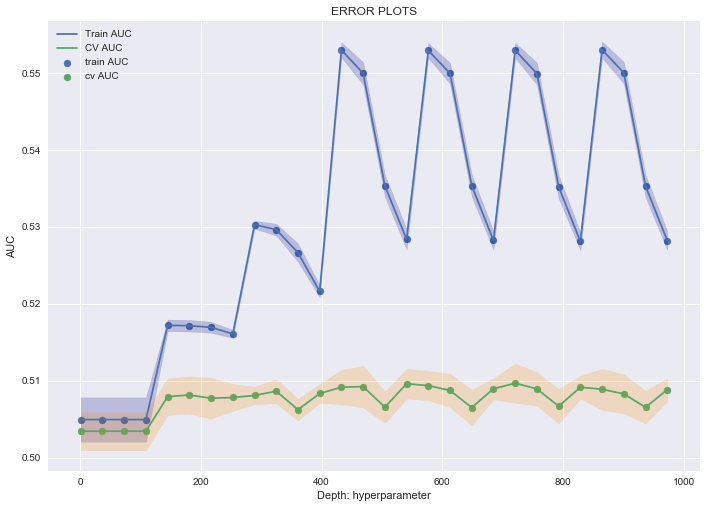

In [97]:
plt.plot(l, train_auc, label='Train AUC')
plt.scatter(l, train_auc, label='train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(l, cv_auc, label='CV AUC')
plt.scatter(l, cv_auc, label='cv AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

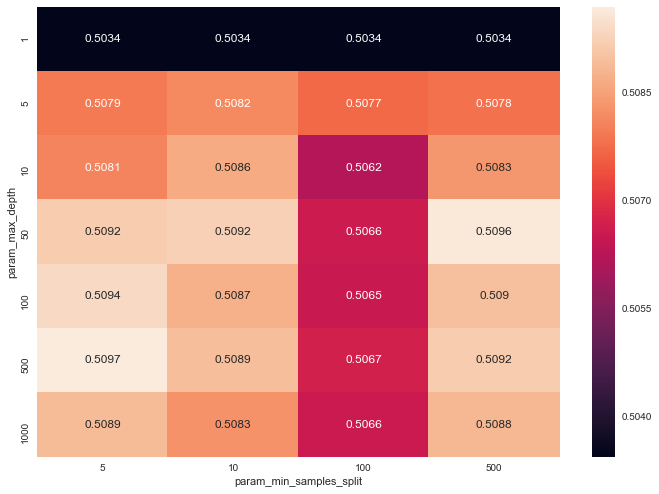

In [101]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.show()

In [98]:
model.best_score_

0.5096859009689569

In [99]:
pred_train= model.predict(tfw2v_train)
cm = confusion_matrix(y_train, pred_train)
cm

array([[  301,  6637],
       [   69, 41993]], dtype=int64)

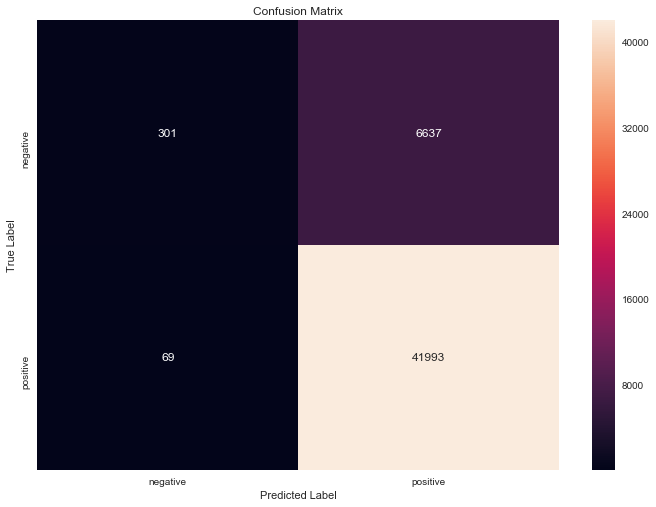

In [100]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on test data

In [103]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth= 500, min_samples_split= 5)
clf.fit(tfw2v_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=500,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

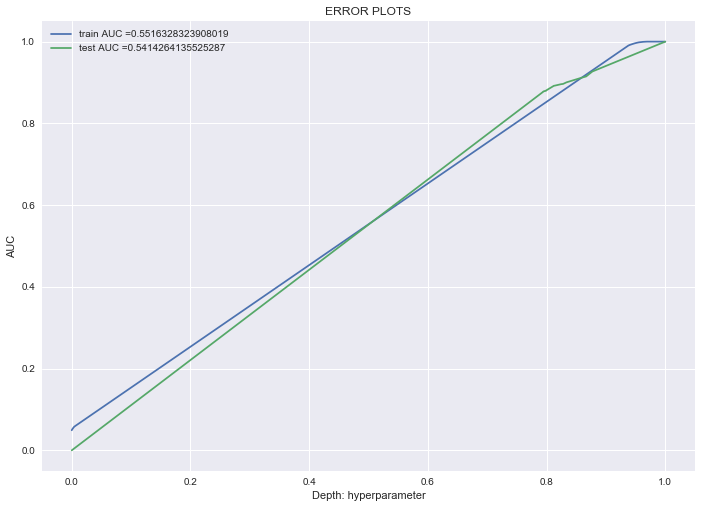

In [104]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(tfw2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(tfw2v_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [105]:
pred = clf.predict(tfw2v_test)
pred_prob = clf.predict_proba(tfw2v_test)[:,1]

In [106]:
# Variables that will be used for  making table in Conclusion part of this assignment
from sklearn.metrics import roc_auc_score
tfw2v_depth = optimal_depth
tfw2v_split = optimal_split

pred_proba_cv = model.predict_proba(tfw2v_cv)[:,1]
tfw2v_cv_auc = roc_auc_score(y_cv, pred_proba_cv)
tfw2v_test_auc=roc_auc_score(y_test, pred_prob)

print("AUC value on test data:",tfw2v_test_auc)

AUC value on test data: 0.5414264135525287


In [107]:
cm = confusion_matrix(y_test, pred)
cm

array([[  873,  4372],
       [ 2466, 22289]], dtype=int64)

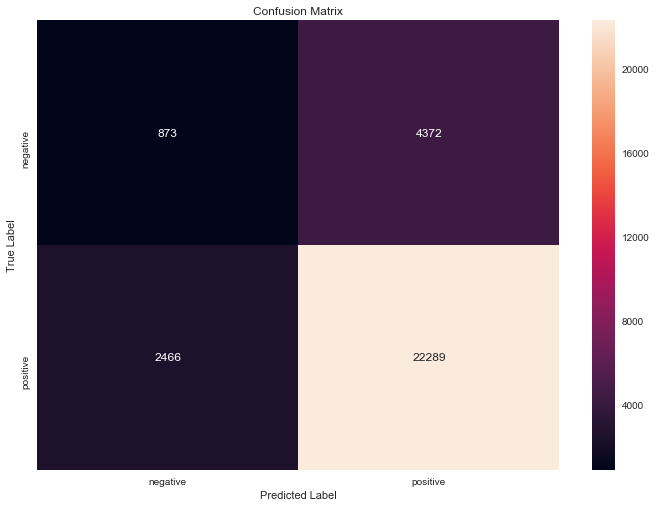

In [108]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [109]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.26      0.17      0.20      5245
          1       0.84      0.90      0.87     24755

avg / total       0.74      0.77      0.75     30000



# [6] Conclusions

In [118]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of the models
names =['Decision_Tree for BoW','Decision_Tree for TFIDF','Decision_Tree for Avg_Word2Vec', 'Decision_Tree for tfidf_Word2Vec']

# Values of optimal depth
optimal_depth1 = [depth, tf_depth,bow_depth,tfw2v_depth]
optimal_split1 = [split,tf_split,bow_split,tfw2v_split]

# CV Accuracies
cv_auc = [bow_cv_auc, tf_cv_auc,avg_cv_auc,tfw2v_cv_auc]

# Test Accuracies
test_auc = [bow_test_auc,tf_test_auc,avg_test_auc, tfw2v_test_auc]
numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Optimal Depth",optimal_depth1)
ptable.add_column("Optimal Min_split",optimal_split1)
ptable.add_column("CV AUC",cv_auc)
ptable.add_column("Test AUC",test_auc)

# Printing the Table
print(ptable)

+-------+----------------------------------+---------------+-------------------+--------------------+--------------------+
| S.NO. |              MODEL               | Optimal Depth | Optimal Min_split |       CV AUC       |      Test AUC      |
+-------+----------------------------------+---------------+-------------------+--------------------+--------------------+
|   1   |      Decision_Tree for BoW       |       50      |        500        | 0.831403187093908  | 0.828022117225454  |
|   2   |     Decision_Tree for TFIDF      |       50      |        500        | 0.8235189817155579 | 0.8229377162156724 |
|   3   |  Decision_Tree for Avg_Word2Vec  |      500      |         5         | 0.8057202235958902 | 0.8026901537835321 |
|   4   | Decision_Tree for tfidf_Word2Vec |      500      |         5         | 0.5061410494024504 | 0.5414264135525287 |
+-------+----------------------------------+---------------+-------------------+--------------------+--------------------+


From above table, we can say that Decision tree for BOW gives decent AUC score compare to others.